# Variant Prioritisation
- BP GWAS data from Evangelou et al. annotated in Hail and from a few external sources (GTEx, DeepSEA, and UCSC genome browser)
- GWAS summary statistics including all 3 phenotype betas (sbp, dbp and pp)
- Positive-unlabelled machine learning applied
    - Curating positive variants via variants pathogenic for cardiovascuar diseases in ClinVar from collated BP GWAS'  
- Evangelou et al. variants found to be significant and in high LD prioritised (approx. 42,000 variants)

    ## Methods tested:
    - XGBoost vs Light GBM
    - PUlearn package vs 'from scratch' positive-unlabelled learning code
    - Replacing heavily missing features' NaNs with zero values (and only imputing <25% complete features vs using only <25% complete features vs using XGB with missing values

## Code Sections:
1. Replacing NaNs with zero values
2. Using only <25% complete features
3. Using the missing values

In [1]:
#import libraries:

import pandas as pd
import numpy as np
import time
import re
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from pulearn import ElkanotoPuClassifier
from pulearn import WeightedElkanotoPuClassifier
from pulearn import BaggingPuClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

import shap
import warnings
warnings.filterwarnings('ignore')


seed = 42

In [2]:
pd_table = pd.read_csv('all_patho_GWAS.csv')
pd_table = pd_table.drop(['BETAmean', "DANN.score","gerp_scores.N",
        "gerp_scores.S"], axis=1)

In [3]:
features = pd_table.drop(['CP', 'label'], axis=1)

## Remove correlating features

In [4]:
#features['label'] = np.where(pd_table['label'] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()

In [5]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [6]:
print(correlated_features)

{'CADD.PHRED_score'}


In [7]:
list(features)

['CADD.raw_score',
 'CADD.PHRED_score',
 'BETAsbp',
 'BETAdbp',
 'BETApp',
 'minP',
 'polyphen_score',
 'sift_score',
 'motif_score_change',
 'REVEL',
 'MVP',
 'GenoCanyon',
 'DEOGEN2',
 'integrated_fitCons',
 'LINSIGHT',
 'SiPhy_29way_logOdds',
 'bStatistic',
 'H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue']

## 1. Replace NaNs with zeros for features that are > 25% missing

In [8]:
pd_table['Y'] = np.where(pd_table['label'] == True, 1, 0)
Y = pd_table['Y']
X = pd_table.drop(['label', 'CP',
                   'Y'], axis=1)

X.drop(labels=correlated_features, axis=1, inplace=True)

In [9]:
X = X.fillna(value=0)

## PULearn Package Implementation:

### XGBoost Bagging

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [11]:
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)

start = time.time()
pu_estimator.fit(X_train, y_train)
end = time.time()
print('Model fitting seconds:', (end - start))

y_pred = pu_estimator.predict_proba(X_test)

Model fitting seconds: 23.408280849456787


In [12]:
y_pred = y_pred[:,1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.79%
f1: 87.88%
roc: 90.26%
recall: 80.56%
precision: 96.67%
balanaced accuracy: 90.26%


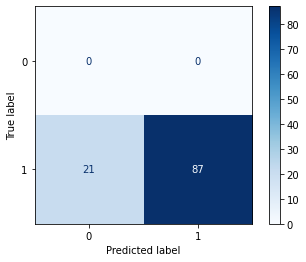

In [13]:
X_test2 = X_test
X_test2['Y'] = y_test
X_pos_test = X_test2[X_test2["Y"] == 1]
X_pos_test = X_pos_test.drop(['Y'], axis=1)
y_pos_test = y_test[y_test == 1]

y_predict_pos = pu_estimator.predict(X_pos_test)
cm = confusion_matrix(y_pos_test, y_predict_pos)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.savefig('confusion_positives.png', format='png', dpi=300, bbox_inches = "tight")

### XGBoost Elkanoto:

In [14]:
estimator = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = ElkanotoPuClassifier(estimator, hold_out_ratio=0.2)
pu_estimator.fit(X_train.values, y_train.values)

X_test = X_test.drop(['Y'], axis=1)
y_pred = pu_estimator.predict_proba(X_test.values)

In [15]:
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.77%
f1: 86.73%
roc: 89.34%
recall: 78.70%
precision: 96.59%
balanaced accuracy: 89.34%


## SHAP view of positives only in test data:

In [16]:
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X_train, y_train)


y_pred = pu_estimator.predict_proba(X_test)

def estimator_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=X_test.columns)
    return pu_estimator.predict(data_asframe)

In [17]:
X_pos_summary = shap.kmeans(X_test, 10)
ex = shap.KernelExplainer(estimator_predict, X_pos_summary)

In [18]:
X_test['Y'] = y_test
y_pos_test = X_test[X_test["Y"] == 1]
y_pos_test = y_pos_test.drop(['Y'], axis=1)
X_test = X_test.drop(['Y'], axis=1)
y_pos_test.shape

(108, 26)

  0%|          | 0/108 [00:00<?, ?it/s]

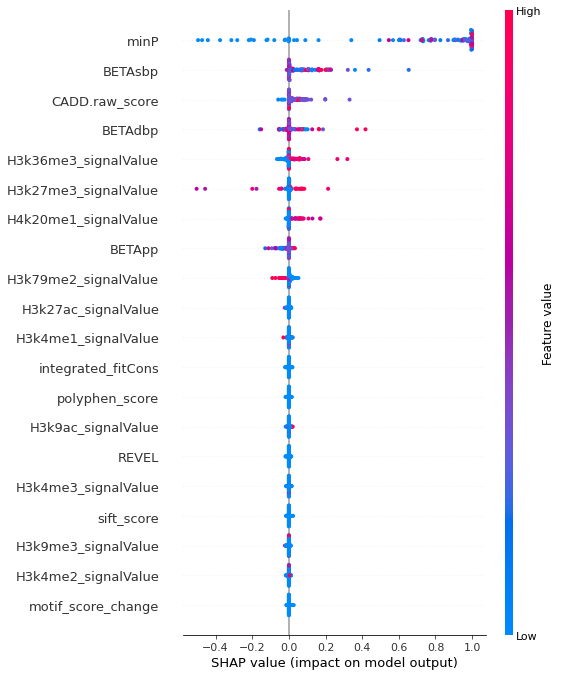

<Figure size 432x288 with 0 Axes>

In [19]:
shap_values = ex.shap_values(y_pos_test)

fig, ax = plt.subplots()
shap.summary_plot(shap_values, y_pos_test)

In [20]:
expected_value = ex.expected_value

  0%|          | 0/108 [00:00<?, ?it/s]

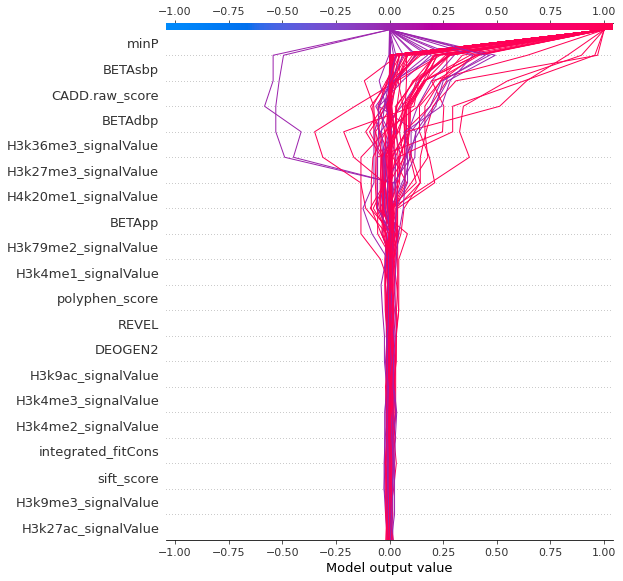

<Figure size 432x288 with 0 Axes>

In [21]:
fig, ax = plt.subplots()
shap.decision_plot(
    expected_value,
    ex.shap_values(y_pos_test),
    list(y_pos_test),
    ignore_warnings=True,
)

## SHAP view of all positives:

In [22]:
def estimator_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=X_test.columns)
    return pu_estimator.predict(data_asframe)

X_pos_summary = shap.kmeans(X, 10)
ex = shap.KernelExplainer(estimator_predict, X_pos_summary)

In [23]:
X['Y'] = Y
y_pos = X[X["Y"] == 1]
y_pos = y_pos.drop(['Y'], axis=1)
X = X.drop(['Y'], axis=1)
y_pos.shape

(401, 26)

  0%|          | 0/401 [00:00<?, ?it/s]

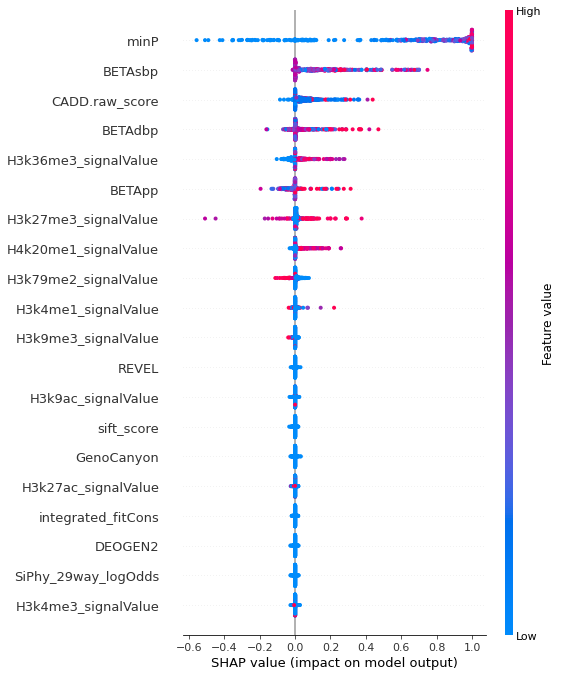

<Figure size 432x288 with 0 Axes>

In [24]:
shap_values = ex.shap_values(y_pos)

fig, ax = plt.subplots()
shap.summary_plot(shap_values, y_pos)

In [25]:
expected_value = ex.expected_value

  0%|          | 0/401 [00:00<?, ?it/s]

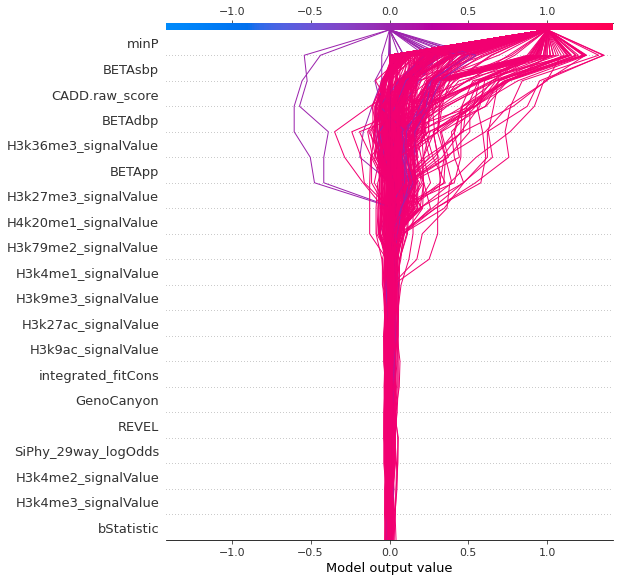

<Figure size 432x288 with 0 Axes>

In [26]:
fig, ax = plt.subplots()
shap.decision_plot(
    expected_value,
    ex.shap_values(y_pos),
    list(y_pos),
    ignore_warnings=True,
)

### LightGBM:

In [27]:
model = lgb.LGBMClassifier(random_state=seed)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict_proba(X_test)

In [28]:
y_pred = y_pred[:,1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.78%
f1: 87.31%
roc: 89.80%
recall: 79.63%
precision: 96.63%
balanaced accuracy: 89.80%


In [29]:
estimator = lgb.LGBMClassifier(random_state=seed)
pu_estimator = ElkanotoPuClassifier(estimator, hold_out_ratio=0.2)
pu_estimator.fit(X_train.values, y_train.values)

y_pred = pu_estimator.predict_proba(X_test.values)

In [30]:
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.76%
f1: 86.01%
roc: 88.42%
recall: 76.85%
precision: 97.65%
balanaced accuracy: 88.42%


In [31]:
def estimator_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=X_test.columns)
    return pu_estimator.predict(data_asframe)

In [32]:
X_pos_summary = shap.kmeans(X_test, 10)
ex = shap.KernelExplainer(estimator_predict, X_pos_summary)

In [33]:
X_test['Y'] = y_test
y_pos_test = X_test[X_test["Y"] == 1]
y_pos_test = y_pos_test.drop(['Y'], axis=1)
X_test = X_test.drop(['Y'], axis=1)

  0%|          | 0/108 [00:00<?, ?it/s]

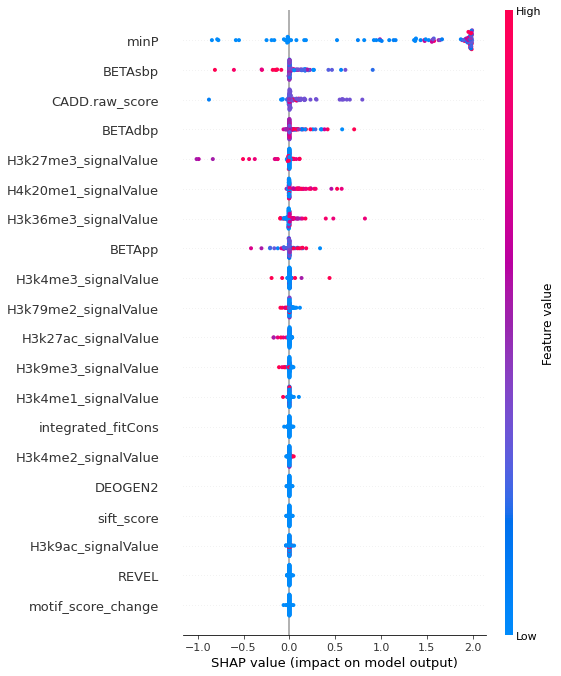

In [34]:
shap_values = ex.shap_values(y_pos_test)

fig, ax = plt.subplots()
shap.summary_plot(shap_values, y_pos_test)

In [35]:
expected_value = ex.expected_value

  0%|          | 0/108 [00:00<?, ?it/s]

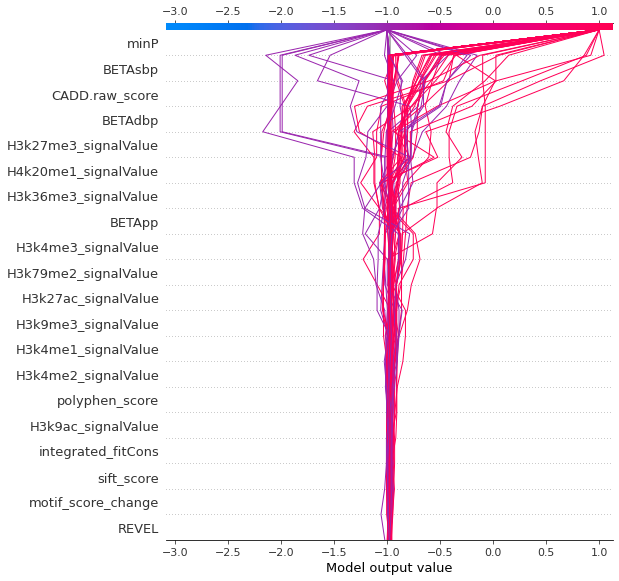

In [36]:
fig, ax = plt.subplots()
shap.decision_plot(
    expected_value,
    ex.shap_values(y_pos_test),
    list(y_pos_test),
    ignore_warnings=True,
)

## From Scratch Code Implementation:
### XGBoost:

In [10]:
X['Y'] = Y
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(401)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

In [12]:
iterations = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(iterations):
    
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    model.fit(data_bootstrap, train_label)
    
   
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 2.8374340534210205


In [13]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))
rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 
bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

XGBoost Classification Results:
Accuracy: 96.25%
F1 Score: 98.09%
recall: 96.25%
precision: 100.00%
balanaced accuracy: 96.25%


## Evaluating test set of both positives and negatives:

In [14]:
df_test_true = df_test.drop(['Y'], axis=1)

y_true = df_test['Y']

y_pred_pos = model.predict_proba(df_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_true, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_true, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))
rec = recall_score(y_true, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_true, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0))
bal = balanced_accuracy_score(y_true, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

XGBoost Classification Results:
Accuracy: 95.84%
F1 Score: 88.51%
recall: 96.25%
precision: 81.91%
balanaced accuracy: 96.01%


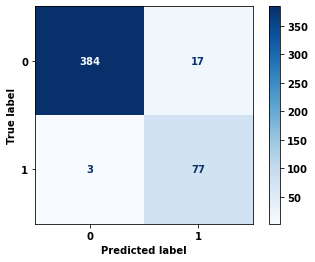

In [15]:
cm = confusion_matrix(y_true, y_predict_pos)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.savefig('Scratch_XGB_confusion.png', format='png', dpi=300, bbox_inches = "tight")

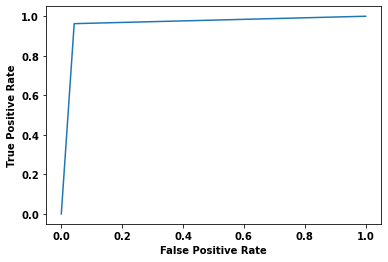

In [16]:
fpr, tpr, _ = roc_curve(y_true, y_predict_pos, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

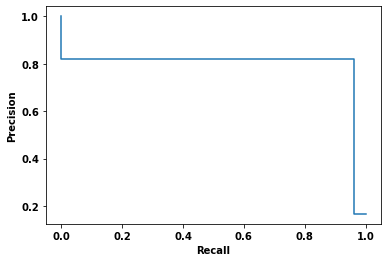

In [17]:
prec, recall, _ = precision_recall_curve(y_true, y_predict_pos, pos_label=model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

## SHAP view of positives only in test data:

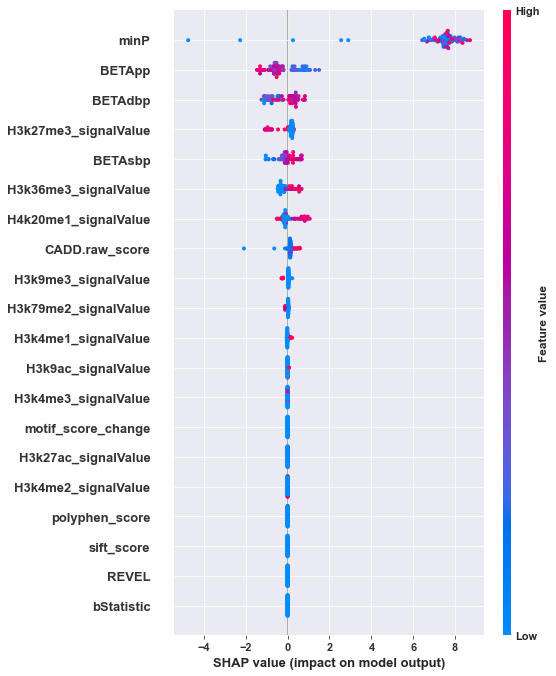

In [19]:
sns.set_style("darkgrid")
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
fig, ax = plt.subplots()
shap.summary_plot(shap_values, data_P_test_true) 
fig.savefig('Scratch_XGB_summary.png', format='png', dpi=300, bbox_inches = "tight")

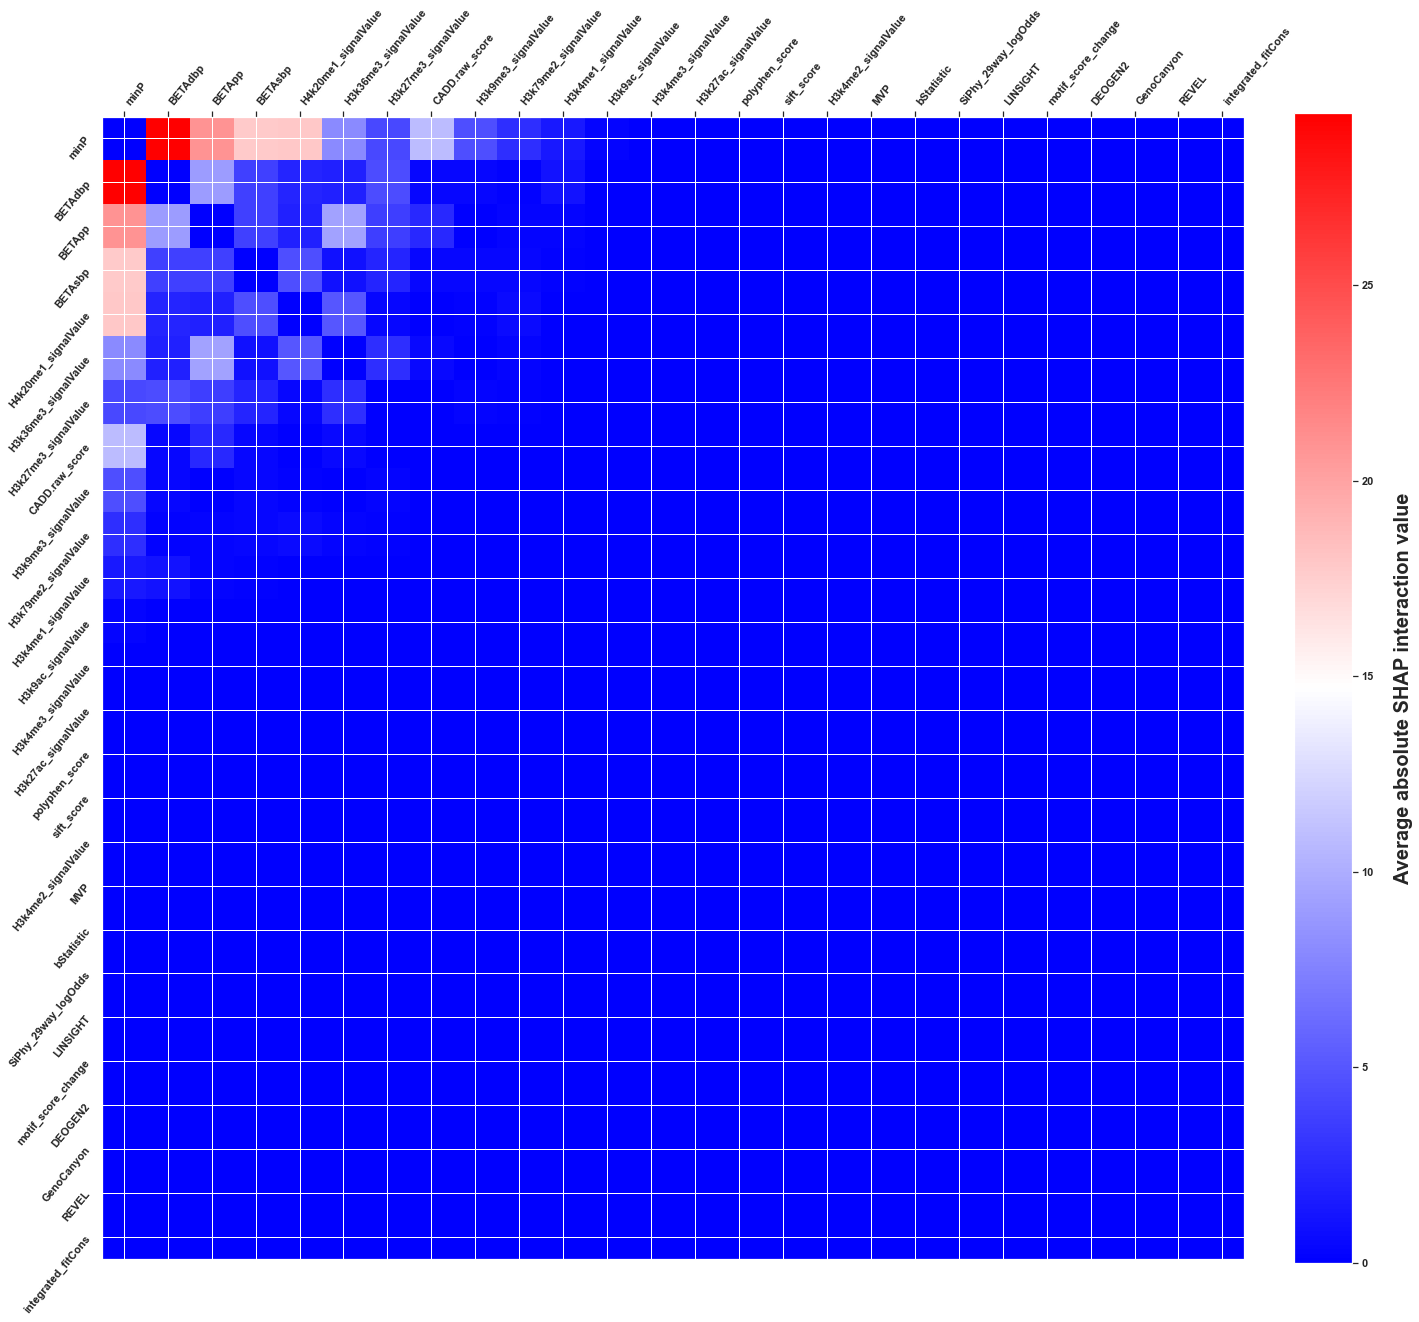

In [20]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(data_P_test_true)

expected_value = explainer.expected_value

tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]

sns.set(font_scale = 1)
f = plt.figure(figsize=(20, 20))
plt.imshow(
    tmp2, cmap="bwr"
)
plt.yticks(
    range(tmp2.shape[0]),
    data_P_test_true.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    data_P_test_true.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=20, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()
plt.savefig('Scratch_XGB_heatmap.png', format='png', dpi=300, bbox_inches = "tight")

In [22]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value

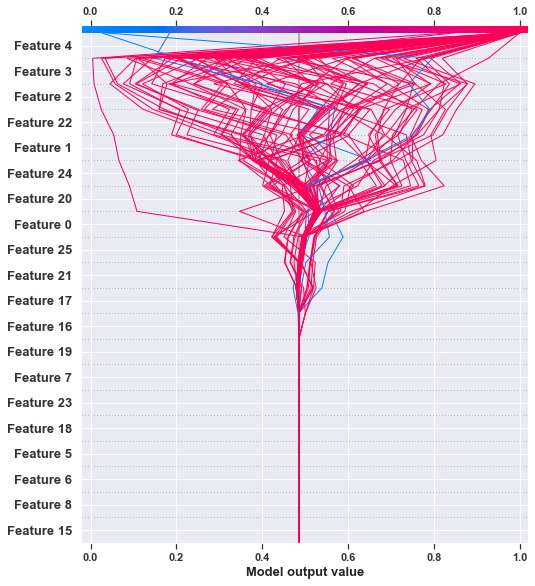

In [23]:
shap.decision_plot(expected_value, shap_values, link='logit')

### Getting all variant probabilities with XGB using from scratch bagging

In [120]:
pd_table['Y'] = np.where(pd_table['label'] == True, 1, 0)
Y = pd_table['Y']
pd_table.set_index('CP', inplace=True)
X = pd_table.drop(['label', 
                   'Y'], axis=1)

X.drop(labels=correlated_features, axis=1, inplace=True)
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
X = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

In [121]:
X['Y'] = Y
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(401)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

In [135]:
X_all = X.drop(['Y'], axis=1)

In [137]:
iterations = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(iterations):
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    model.fit(data_bootstrap, train_label)
    
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
    
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 2.6687276363372803


In [143]:
output1 = data_U
output1['CP'] = output1.index

In [144]:
output2 = output1[['CP']]
output2 = output2.reset_index(drop=True)

In [145]:
output2

,CP
0,10:102075479
1,10:102552663
2,10:102552752
3,10:102553647
4,10:102554618
...,...
36519,9:95323297
36520,9:95336327
36521,9:95337520
36522,9:96176203


In [146]:
prob_df

,XGB_Probability
0,0.007936
1,0.006197
2,0.006141
3,0.006197
4,0.010178
...,...
36519,0.001582
36520,0.001698
36521,0.005343
36522,0.494732


In [147]:
prob_df =  pd.DataFrame(predict_proba)
prob_df.rename(columns={prob_df.columns[0]: "XGB_Probability"}, inplace=True)
result = output2.join(prob_df)
result

,CP,XGB_Probability
0,10:102075479,0.004725
1,10:102552663,0.008510
2,10:102552752,0.008360
3,10:102553647,0.008435
4,10:102554618,0.009301
...,...,...
36519,9:95323297,0.000893
36520,9:95336327,0.033001
36521,9:95337520,0.000893
36522,9:96176203,0.005704


In [149]:
result.to_csv('XGB_probabilities.csv',index=False)

### LightGBM from scratch bagging performance:

In [83]:
iterations = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(iterations):
    
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    
    model = lgb.LGBMClassifier(random_state=seed)
    
    model.fit(data_bootstrap, train_label)
   
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 3.799783945083618


In [84]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('LightGBM Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

LightGBM Classification Results:
Accuracy: 91.25%
F1 Score: 95.42%
recall: 91.25%
precision: 100.00%
balanaced accuracy: 91.25%


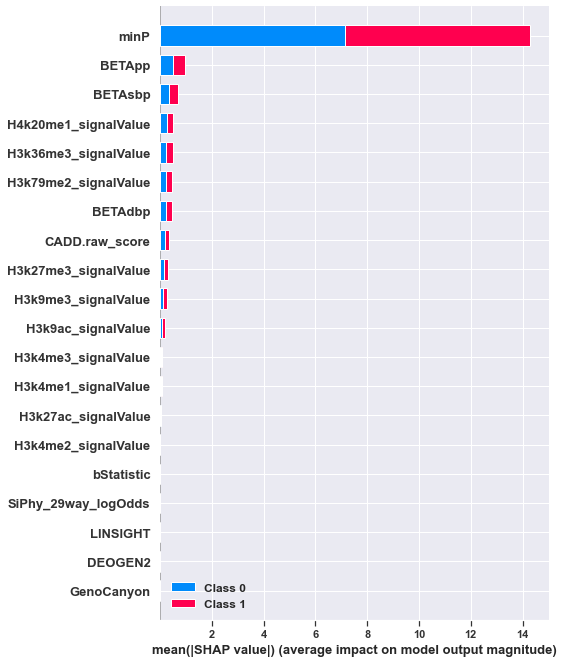

In [50]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values, data_P_test_true) 

In [51]:
df_test_true = df_test.drop(['Y'], axis=1)

y_true = df_test['Y']

y_pred_pos = model.predict_proba(df_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]

print('XGBoost Classification Results:')
acc = accuracy_score(y_true, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_true, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))
rec = recall_score(y_true, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_true, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 
bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

XGBoost Classification Results:
Accuracy: 96.47%
F1 Score: 89.82%
recall: 93.75%
precision: 86.21%
balanaced accuracy: 88.42%


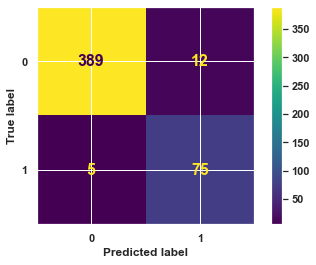

In [52]:
cm = confusion_matrix(y_true, y_predict_pos)

cm_display = ConfusionMatrixDisplay(cm).plot()

# 2. Using only <50% complete features

In [85]:
pd_table['Y'] = np.where(pd_table['label'] == True, 1, 0)
Y = pd_table['Y']
X = pd_table.drop(['label','CP', 
                   'Y'], axis=1)

X.drop(labels=correlated_features, axis=1, inplace=True)
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
X = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

X = X[['BETAsbp',
 'BETAdbp',
 'BETApp',
 'minP',
 'CADD.raw_score']]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### PULean Package with XGBoost:

In [70]:
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict_proba(X_test)

In [71]:
y_pred = y_pred[:,1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.72%
f1: 83.67%
roc: 87.94%
recall: 75.93%
precision: 93.18%
balanaced accuracy: 87.94%


In [72]:
estimator = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = ElkanotoPuClassifier(estimator, hold_out_ratio=0.2)
pu_estimator.fit(X_train.values, y_train.values)

y_pred = pu_estimator.predict_proba(X_test.values)

In [73]:
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.70%
f1: 82.65%
roc: 87.47%
recall: 75.00%
precision: 92.05%
balanaced accuracy: 87.47%


In [74]:
model = lgb.LGBMClassifier(random_state=seed)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict_proba(X_test)

In [75]:
y_pred = y_pred[:,1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.69%
f1: 82.23%
roc: 87.46%
recall: 75.00%
precision: 91.01%
balanaced accuracy: 87.46%


In [61]:
estimator = lgb.LGBMClassifier(random_state=seed)
pu_estimator = ElkanotoPuClassifier(estimator, hold_out_ratio=0.2)
pu_estimator.fit(X_train.values, y_train.values)

y_pred = pu_estimator.predict_proba(X_test.values)

In [62]:
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.72%
f1: 84.16%
roc: 89.31%
recall: 78.70%
precision: 90.43%
balanaced accuracy: 89.31%


In [87]:
X['Y'] = Y
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(207)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

iterations = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(iterations):
    
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    
    model.fit(data_bootstrap, train_label)
   
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 2.4169819355010986


In [88]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

XGBoost Classification Results:
Accuracy: 88.75%
F1 Score: 94.04%
recall: 88.75%
precision: 100.00%
balanaced accuracy: 88.75%


In [90]:
iterations = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(iterations):
    
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    
    model = lgb.LGBMClassifier(random_state=seed)
    
    model.fit(data_bootstrap, train_label)
   
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('LightGBM Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Model fitting seconds: 6.024536848068237
LightGBM Classification Results:
Accuracy: 87.50%
F1 Score: 93.33%
recall: 87.50%
precision: 100.00%
balanaced accuracy: 87.50%


# 3. XGBoost with missing values:

In [14]:
pd_table = pd.read_csv('all_patho_GWAS.csv')

In [15]:
cols = ['H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue',
 'polyphen_score',
 'sift_score',
 'motif_score_change',
 'REVEL',
 'MVP',
 'GenoCanyon',
 'DEOGEN2',
 'integrated_fitCons',
 'LINSIGHT',
 'SiPhy_29way_logOdds',
 'bStatistic',]
pd_table[cols] = pd_table[cols].replace(0, np.nan)

In [16]:
pd_table['Y'] = np.where(pd_table['label'] == True, 1, 0)
Y = pd_table['Y']
X = pd_table.drop(['label', 'CP','BETAmean',
                   'Y'], axis=1)


In [17]:
X['Y'] = Y
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(401)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

In [18]:
iterations = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for iterations in range(iterations):
    
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    
    model.fit(data_bootstrap, train_label)
   
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 2.5772719383239746


In [19]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

XGBoost Classification Results:
Accuracy: 97.50%
F1 Score: 98.73%
recall: 97.50%
precision: 100.00%
balanaced accuracy: 97.50%


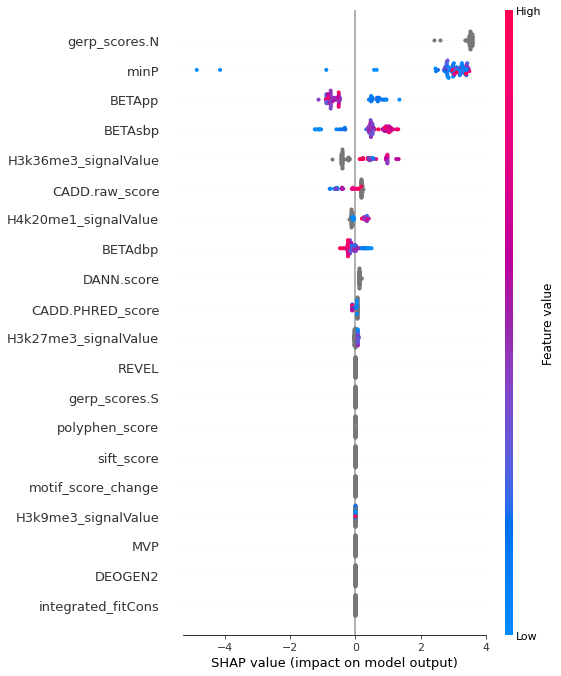

In [20]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values, data_P_test_true) 

In [21]:
T = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(T):
    
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    
    model =  lgb.LGBMClassifier(random_state=seed)
    
    model.fit(data_bootstrap, train_label)
   
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 10.998971223831177


In [22]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('LightGBM Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

LightGBM Classification Results:
Accuracy: 98.75%
F1 Score: 99.37%
recall: 98.75%
precision: 100.00%
balanaced accuracy: 98.75%


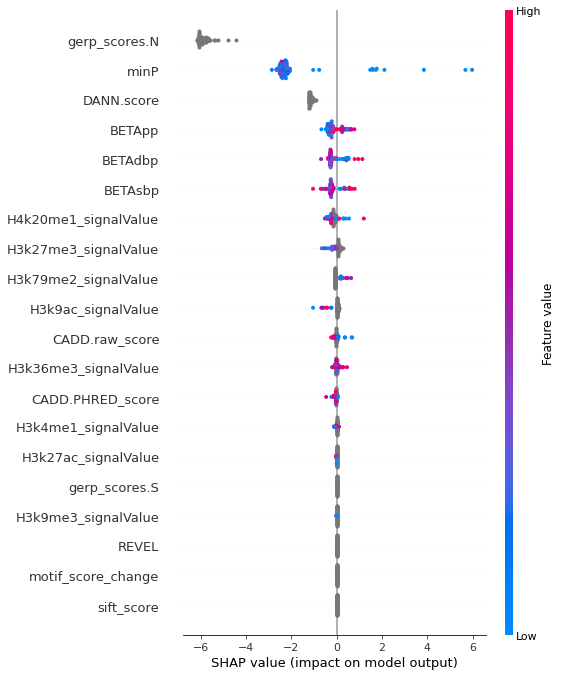

In [23]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values[0], data_P_test_true) 

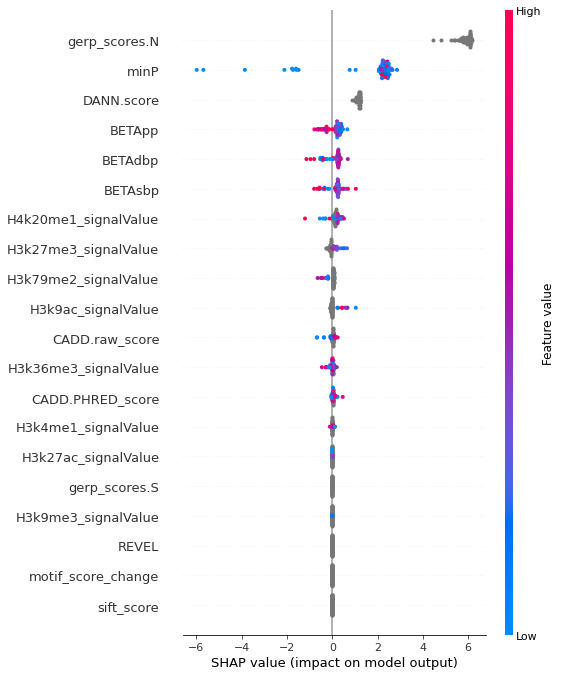

In [24]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values[1], data_P_test_true) 